In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch
import pandas as pd
import numba
from skopt import dump, load


In [2]:
sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line.upper()
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line.upper()
            sid = ''
mat3di = np.load('data/mat3di.npy') * 2.1
blosum = np.load('data/blosum62.npy') * 1.4
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return np.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = np.array(np.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = np.array(np.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S
def distances(q_points_aln, t_points_aln):
    d_mat = cdist(q_points_aln, t_points_aln)
    return (d_mat)

In [3]:
coord_dir = 'data/pdb/d*'
if not os.path.exists(coord_dir):
    print('Creating cache first.')
    sautils.encoder_commons.init_coords('data/pdb/d*', coord_dir)
sid2coords = {sid: sautils.encoder_commons.read_coords(coord_dir, sid) for sid in sautils.encoder_commons.list_sids(coord_dir)}

In [4]:
@numba.jit(nopython=True)
def fill_dp_matrix(scores, gap_open, gap_extend):
    l1, l2 = scores.shape
    s, q_gap, t_gap = np.zeros((l1+1, l2+1)), np.zeros((l1+1, l2+1)), np.zeros((l1+1, l2+1))
    for i in range(1, l1+1):
        for j in range(1, l2+1):
            q_gap[i, j] = max(q_gap[i, j-1] - gap_extend, s[i, j-1] - gap_open)
            t_gap[i, j] = max(t_gap[i-1, j] - gap_extend, s[i-1, j] - gap_open)
            s[i, j] = max(0,
                          q_gap[i, j],
                          t_gap[i, j],
                          s[i-1, j-1] + scores[i-1, j-1])
    return s, q_gap, t_gap

def backtrace_alignment(scores, gap_open, gap_extend, s, q_gap, t_gap):
    S_MAT, QGAP_MAT, TGAP_MAT = 0, 1, 2
    arg_max = np.where(s == s.max())
    i, j, pos = arg_max[0][0], arg_max[1][0], S_MAT
    backtrace = []
    while (s[i, j] > 0 or pos != S_MAT) and (i > 0 and j > 0):
        if pos == S_MAT:
            if s[i, j] == q_gap[i, j]:
                if q_gap[i,j] == q_gap[i, j-1] - gap_extend:
                    pos = QGAP_MAT
                j = j - 1       
            elif s[i, j] == t_gap[i, j]:
                if t_gap[i,j] == t_gap[i-1, j] - gap_extend:
                    pos = TGAP_MAT
                i = i - 1
            elif s[i,j] == s[i-1, j-1] + scores[i-1, j-1]:
                backtrace.append((i,j))
                i, j = i - 1, j - 1                
            else:
                break        
        elif pos == QGAP_MAT:
            if q_gap[i, j] == s[i, j-1] - gap_open:
                pos = S_MAT
            j = j - 1
            
        elif pos == TGAP_MAT:
            if t_gap[i, j] == s[i-1, j] - gap_open:
                pos = S_MAT
            i = i - 1
    return list(reversed([(i-1, j-1) for i, j in backtrace]))

def sw_align(scores, gap_open=30, gap_extend=10):    
    s, q_gap, t_gap = fill_dp_matrix(scores, gap_open, gap_extend)
    backtrace = backtrace_alignment(scores, gap_open, gap_extend, s, q_gap, t_gap)
    return backtrace, (s, q_gap, t_gap)

def format_aln(seq1, seq2, bt):
    s1, s2 = '', ''
    i_prev, j_prev = None, None
    for i, j in bt:        
        if i_prev is not None:
            s1 += seq1[i_prev+1:i] + '-' * len(seq2[j_prev+1:j])
            s2 += '-' * len(seq1[i_prev+1:i]) + seq2[j_prev+1:j]                
        s1 += seq1[i]
        s2 += seq2[j]
        i_prev, j_prev = i, j
    return s1, s2

In [5]:
def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    #vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
    #wj = np.exp((np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)) /T)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    
    return P
    
def fb_global(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1]) * np.exp(-S/T, dtype = pre)
    
    return P
def fb_local_global(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1])* np.exp(-S/T, dtype = pre)
    
    return P
    
def fb_global_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ np.sum(zm) * np.exp(-S/T)
    
    return P

In [6]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]

def forward_backward_plain_global(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    zm[0,0] = 1
    ze[0,1:] = np.exp(np.linspace(go,go+(ge*(S.shape[1]-1)),S.shape[1])/T, dtype = pre)

    #exp_ge_arr = np.exp((np.arange(ge, (S.shape[1] + 1)* ge ,ge,dtype = pre))/T, dtype = pre)
                        
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = (zm[i-1, :-1] + ze[i-1,:-1] + zf[i-1,:-1]) * S[i-1,:]
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) #+  * exp_ge_arr
        zf[i,:] = zm[i-1,:] * exp_go + zf[i-1,:] * exp_ge
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]

In [7]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]
def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    #vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
    #wj = np.exp((np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)) /T)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    
    return P

In [8]:
fused_model = torch.load('data/distance_model_integrated_1.torch')

w_list = [fused_model[i].weight.detach().numpy() for i in [0, 2, 4, 6, 8]]
bias_list = [fused_model[i].bias.detach().numpy() for i in [0, 2, 4, 6, 8]]


def lol_score_np(d_ij, d_kl, d_seq):    
    x = np.stack(
        [np.log(np.divide(d_ij, d_kl, out=np.zeros_like(d_ij), where = (d_kl != 0))),
         np.log(d_ij, where = (d_ij != 0)),
         np.log(d_kl, where = (d_kl != 0)),
         np.sign(d_seq) * np.log(1 + np.abs(d_seq)),
        ],
        axis=-1)
    # NN
    for w, bias in zip(w_list[:-1], bias_list[:-1]):
        x = ReLU((x @ w.T) + bias)
    x = (x @ w_list[-1].T) + bias_list[-1]  # last layer has no ReLU
    p = sig(x)
    # Probabilities to log odd scores
    score = np.log(p / (1-p)).reshape(-1)
    return score

def ReLU(x):
    return np.where(x > 0, x, 0)
    #return x * (x > 0)
def sig(x):
    return 1/(1 + np.exp(-x)) 

def lol_score_approx(d_ij, d_kl, d_seq):
    seq_distance_feat = np.sign(d_seq) * np.log(1 + np.abs(d_seq))
    x = np.hstack([seq_distance_feat[:, None], np.abs(d_ij-d_kl)[:, None],])

    w1 = np.array([[-1.3584513e-04,  9.9329501e-01],
                   [ 7.6149112e-01,  5.7029408e-01],
                   [-8.1348085e-01,  6.0702705e-01]])
    b1 = np.array([0.7043129 , 0.374659  , 0.39905924])
    w2 = np.array([[-0.776632  ,  0.61055756,  0.5823986 ]])
    b2 = np.array([-0.11200039])

    hidden_layer = ((x @ w1.T) + b1)
    hidden_layer *= (hidden_layer > 0)  # if w1 is all positive, we dont need this ReLU
    score = (hidden_layer @ w2.T) + b2
    return np.squeeze(score)

In [9]:
def calc_startAnchors(S, fb_go, fb_ge, temp, le):
    start_anchors = []
    for i in range(2):
        P = fb_local(S, fb_go, fb_ge, temp, np.longdouble)
        x,y = np.unravel_index(np.argmax(P), P.shape)
        x,y = np.max([0,x-le]), np.max([0,y-le])
        #P -= np.max([0 ,np.max(P)-shift])
        bt, (s, q_gap, t_gap) = sw_align(np.array(P[x:x+(le*2),y:y+(le*2)], dtype = np.double), gap_open = 0, gap_extend=0)
        bt = np.array(bt)
        bt[:,0] += x
        bt[:,1] += y
        start_anchors.append(np.copy(bt))
        S[bt[:,0], bt[:,1]] = - 100
    return start_anchors


In [10]:
def get_gaps(A_all):
    lowerBounds_i = (A_all[:,0]+1)[:-1]
    upperBounds_i = (A_all[:,0]-1)[1:]
    lowerBounds_k = (A_all[:,1]+1)[:-1]
    upperBounds_k = (A_all[:,1]-1)[1:]
    mask_i = lowerBounds_i<=upperBounds_i
    mask_k = lowerBounds_k<=upperBounds_k
    mask = np.logical_and(mask_i,  mask_k)
    return np.array([np.sort(np.array([lowerBounds_i[mask],upperBounds_i[mask]+1]).reshape(-1)),
                    np.sort(np.array([lowerBounds_k[mask],upperBounds_k[mask]+1]).reshape(-1))])

In [11]:
def lol_matrix_johannes(A_new, gaps,d_mat_ij, d_mat_kl):
    #nn = S.shape[0]-1
    d_ij, d_kl = d_mat_ij, d_mat_kl#= np.array(d_mat_ij[A_new[:,0],gaps[0,0]:gaps[0,1]]), np.array(d_mat_kl[A_new[:,1],gaps[1,0]:gaps[1,1]])
    G_mat = np.zeros((gaps[0,1]-gaps[0,0], gaps[1,1]-gaps[1,0]))
    for steps in range(A_new.shape[0]):
        i,k = A_new[steps, 0], A_new[steps,1]
        Bi = np.argsort(d_mat_ij[i,:])[1:]
        #Bi = np.argwhere(d_ij[steps,:]).reshape(-1)
        ti = np.repeat(d_ij[steps,Bi], d_kl.shape[1])
        tidx = np.repeat(steps - Bi, d_kl.shape[1])
        tk = np.repeat(d_kl[steps,:].reshape(1,-1), Bi.shape[0], axis = 0).reshape(-1)
        G_mat[Bi, :] += lol_score_approx(ti, tk, tidx).reshape(-1,G_mat.shape[1])
    return G_mat
        

In [25]:
query, target = "d2v33a_", "d1r17a2"
coords1,_ = sid2coords.get(query)
coords2,_ = sid2coords.get(target)
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = np.asarray(d_mat_ij)
d_mat_kl = np.asarray(d_mat_kl)
aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
#A_new = calc_startAnchors(S, -30, -10, 4, 3)
#plt.imshow(lol_matrix_johannes(A_new[0], np.array([[0,0],[S.shape[0], S.shape[1]]]).T,d_mat_ij, d_mat_kl))

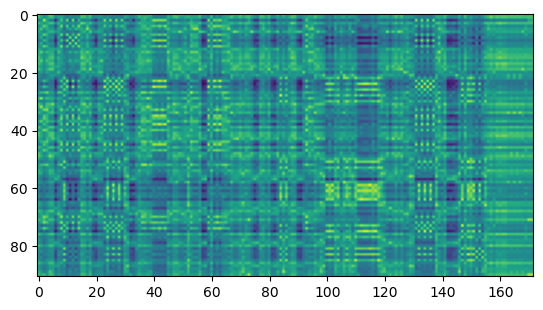

In [26]:
plt.imshow(S)

In [285]:
S_al = align(S, A_new, -3, -.3, .4, .1, 3, .1, d_mat_ij, d_mat_kl)

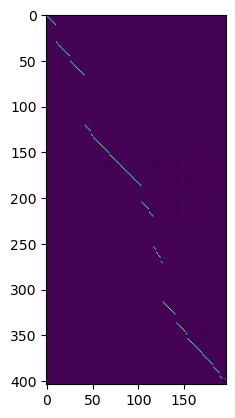

In [286]:
S_al[0][S_al[0]>= 1e2] = 1e4
plt.imshow(S_al[0])

In [287]:
al = np.argwhere(S_al[0] >=1e2)

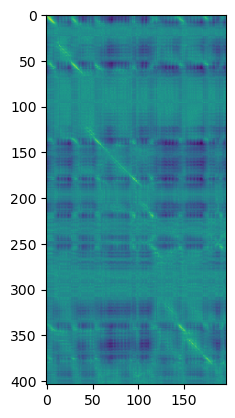

In [289]:
plt.imshow(lol_matrix_gap_dist_aprox(al, al, np.array([[0,0],[S.shape[0], S.shape[1]]]).T,d_mat_ij, d_mat_kl, lol_score_approx, lol_matrix_prep_gaps) + S)

In [290]:
lol3di_mat = lol_matrix_gap_dist_aprox(al, al, np.array([[0,0],[S.shape[0], S.shape[1]]]).T,d_mat_ij, d_mat_kl, lol_score_approx, lol_matrix_prep_gaps) + S

In [291]:
lol3di_fb = fb_local(lol3di_mat, -10, -1, 3, np.longdouble)

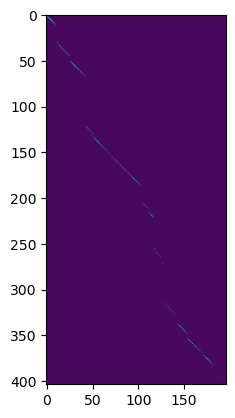

In [293]:
plt.imshow(lol3di_fb * lol3di_mat)

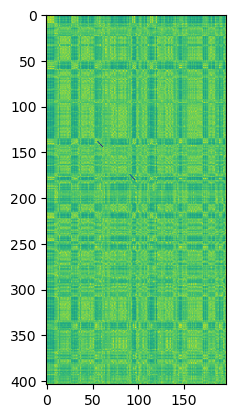

In [154]:
plt.imshow(S)

In [12]:
def lol_matrix_gap_dist_aprox(A, All_a, gaps,d_mat_ij, d_mat_kl, lol_score_jax, lol_matrix_prep):

    ti, tk, tidx = lol_matrix_prep_gaps(A, All_a, gaps, d_mat_ij, d_mat_kl)
    idx = np.logical_and(ti > 0, tk > 0)
    G_mat = np.zeros_like(ti)
    G_mat[idx] += np.nan_to_num(lol_score_jax(ti[idx], tk[idx], tidx[idx]))
    norm = idx.reshape(gaps[0,1]-gaps[0,0], gaps[1,1]-gaps[1,0], -1).sum(axis = 2) +1
    return G_mat.reshape(gaps[0,1]-gaps[0,0], gaps[1,1]-gaps[1,0], -1).sum(axis=2)/norm

In [13]:
def lol_matrix_prep_gaps(A, All_a, gaps,d_mat_ij, d_mat_kl):
    #print(d_mat_ij[:,gaps[0,0]:gaps[0,1]].shape, d_mat_kl[:,gaps[1,0]:gaps[1,1]].shape)
    d_ij, d_kl = np.array(d_mat_ij[A[:,0],gaps[0,0]:gaps[0,1]]), np.array(d_mat_kl[A[:,1],gaps[1,0]:gaps[1,1]])
    
    
    ti = np.repeat(d_ij.T, gaps[1,1] - gaps[1,0], axis = 0).reshape(-1)
    tk = np.repeat(d_kl.T.reshape(-1,1), gaps[0,1]-gaps[0,0], axis = 1).T.reshape(-1)
    tidx = np.repeat(A[:,0].reshape(1,-1), d_ij.shape[1] * d_kl.shape[1], axis = 0).reshape(-1)
    #print(ti.shape, tk.shape, tidx.shape, np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0]).shape)
    tidx = tidx - np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0])

    return ti, tk, tidx

In [14]:
def align(S, startAnchors, go, ge, min_m, red_m, temp, red_t, d_mat_ij, d_mat_kl):
    S_all = []
    pre = np.longdouble
    lol_matrix_prep = lol_matrix_prep_gaps
    for j in range(2):
        num_all = 0
        th = .99
        tempr = temp
        S = np.zeros_like(S, dtype = pre)
        A_new = startAnchors[j]
        A_all = startAnchors[j]
        
        #print(j)

        for i in (range(500)):
            S[A_all[:,0], A_all[:,1]] = 1e2
            gaps_idn = get_gaps(np.unique(np.concatenate((np.array([-1,-1]).reshape(1,2), A_all, np.array([S.shape[0], S.shape[1]]).reshape(1,2))), axis = 0))
            P = np.zeros_like(S)
            #S += lol_matrix_gap_dist(A_new, A_all,d_mat_ij, d_mat_kl, lol_score_approx)
            #S += lol_matrix_gap_dist_aprox(A_new, A_all, np.array([[0,0],[S.shape[0], S.shape[1]]]).T ,d_mat_ij, d_mat_kl, lol_score_approx, lol_matrix_prep)

            for g in range(0, gaps_idn.shape[1], 2):
                S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] += lol_matrix_gap_dist_aprox(A_new, A_all, gaps_idn[:,g:g+2] ,d_mat_ij, d_mat_kl, lol_score_approx, lol_matrix_prep)
            for g in range(0, gaps_idn.shape[1], 2):
                P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                if (g == 0 and gaps_idn[0,g] == 0 and gaps_idn[1,g] == 0):
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_local_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                elif(g == (gaps_idn.shape[1]-2), gaps_idn[0,g+1] == S.shape[0], gaps_idn[1,g+1] == S.shape[1]):
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_local_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                    
                else:
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                    

            #P[A_all[:,0], A_all[:,1]] = 0
            m = np.max(P)
            if np.isnan(m):
                print("NaN")
                break

            if m <= min_m:
                break
                num_all += 2
                if num_all >= 4:
                    #print(i, A_all.shape)
                    break
                tempr = np.max([2, tempr - red_t])
                A_new = A_all#[::2]
            else:
                A_new = np.argwhere(P >= np.max([m - red_m, min_m]))
                A_all = np.vstack((A_all, A_new))
                A_all = np.sort(A_all, axis = 0)
                num_all -= 1
                tempr = np.max([tempr-red_t, 1])
        S[A_all[:,0], A_all[:,1]] = 1e2
        S_all.append(np.copy(S))
    return S_all

In [15]:
def calc_score(S_all, S_3di, go, ge, temp, th, d_mat_ij, d_mat_kl, query, target):
    lol_score =  0
    pre = np.longdouble
    
    all_lolscores = np.zeros(len(S_all))

    for i in range(len(S_all)):
        #ap = S_all[i]
        ap = np.argwhere(S_all[i] == 1e2)
        gaps = np.array([[0,0],[S_3di.shape[0], S_3di.shape[1]]]).T
        #S = lol_matrix_gap_dist_aprox(ap, ap, gaps ,d_mat_ij, d_mat_kl, lol_score_approx, lol_matrix_prep_gaps)+ S_3di
        S = np.load("hyperparameter/scope100_first1000_3di/"+query+"_"+target+"_"+str(i)+".npy")
        P = fb_local(S, go, ge, temp, pre)
        #th = 0.51
        #ap = np.argwhere(P >= th)
        #np.save("hyperparameter/scope100_first1000_3di/"+query+"_"+target+"_"+str(i)+".npy", S)

        #index_test = (ap[:,0]).reshape(-1)[None,:] - ap[:,1][:,None]
        #d_mat_ij_test = d_mat_ij[:, ap[:,0]]
        #d_mat_ij_test = d_mat_ij_test[ap[:,0], :]
        #d_mat_kl_test = d_mat_kl[:,ap[:,1]]
        #d_mat_kl_test = d_mat_kl_test[ap[:,1], :]
        #d_mask_test = d_mat_ij_test > 0
        

        #d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
        #_lol_scores = lol_score_approx(d_ij_test, d_kl_test, d_seq_test)
        #all_lolscores[i] = np.sum(_lol_scores)
    #print(all_lolscores)
    return np.max(all_lolscores)

In [60]:
alignments[(alignments[0] == 'd1bf6a_') & alignments[1] == 'd2a3la1']

,0,1,2,3


In [57]:
score_anchor = np.zeros(50000)
ite = -1
for query,target in tqdm(zip(alignments[0].values, alignments[1].values), total = len(alignments[0].values)):
    ite+=1
    coords1,_ = sid2coords.get(query)
    coords2,_ = sid2coords.get(target)
    coords1 = coords1[:,:3]
    coords2 = coords2[:,:3]
    d_mat_ij = distances(coords1, coords1)
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2, coords2)
    d_mat_ij = np.asarray(d_mat_ij)
    d_mat_kl = np.asarray(d_mat_kl)
    aa1 = sid2seq_aa[query]
    aa2 = sid2seq_aa[target]
    ss1 = sid2seq_ss[query]
    ss2 = sid2seq_ss[target]
    S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
    S_all = []
    if query== target:
        for i in range(2):
            S_all.append(np.array([np.arange(S.shape[0]),np.arange(S.shape[0])]))
    else:
        for i in range(2):
            S_all.append(np.load("hyperparameter/scope100_first1000/"+query+"_"+target+"_"+str(i)+".npy")) #+S
    calc_score(S_all, S, -10, -1, 2, .5, d_mat_ij, d_mat_kl, query, target)
    
    
    #score_anchor[ite] = calc_score2(S_all, S, -10, -1, 2, .5, d_mat_ij, d_mat_kl)
    #print(score_anchor[ite], S_all[0].shape, ite)
    #score += sc

100%|███████████████████████████████████████| 2484/2484 [28:38<00:00,  1.45it/s]


In [242]:
score_lolmat = np.zeros(50000)
ite = -1
for query,target in tqdm(zip(alignments[0].values, alignments[1].values), total = len(alignments[0].values)):
    ite+=1
    coords1,_ = sid2coords.get(query)
    coords2,_ = sid2coords.get(target)
    coords1 = coords1[:,:3]
    coords2 = coords2[:,:3]
    d_mat_ij = distances(coords1, coords1)
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2, coords2)
    d_mat_ij = np.asarray(d_mat_ij)
    d_mat_kl = np.asarray(d_mat_kl)
    aa1 = sid2seq_aa[query]
    aa2 = sid2seq_aa[target]
    ss1 = sid2seq_ss[query]
    ss2 = sid2seq_ss[target]
    S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
    S_all = []
    
    for i in range(2):
        S_all.append(np.load("hyperparameter/scope100_first1000/"+query+"_"+target+"_"+str(i)+".npy")) #+S
    if query == target:
        S_all[0] *= 1e2 
    score_lolmat[ite] = (calc_score(S_all, S, -10, -1, 2, .5, d_mat_ij, d_mat_kl, query, target))
    #print(score_lolmat[ite], S_all[0].shape, ite)
    #score += sc

  0%|                                                             | 0/43002 [00:00<?, ?it/s]


NameError: name 'd_mask_test' is not defined

In [67]:
S = np.load("hyperparameter/scope100_first1000/d2v33a__d1um0a__1.npy")
coords1,_ = sid2coords.get("d2v33a_")
coords2,_ = sid2coords.get("d1um0a_")
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = np.asarray(d_mat_ij)
d_mat_kl = np.asarray(d_mat_kl)
calc_score2([S,S],d_mat_ij, d_mat_kl)

3343.052942309319

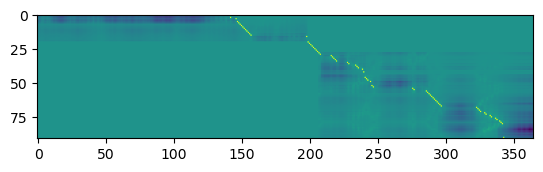

In [68]:
plt.imshow(S)

In [50]:
S = np.load("hyperparameter/scope100_first1000/d2v33a__d1f00i1_0.npy")
coords1,_ = sid2coords.get("d2v33a_")
coords2,_ = sid2coords.get("d1f00i1")
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)
d_mat_ij = np.asarray(d_mat_ij)
d_mat_kl = np.asarray(d_mat_kl)
calc_score2([S,S],d_mat_ij, d_mat_kl)

1637.8777907558583

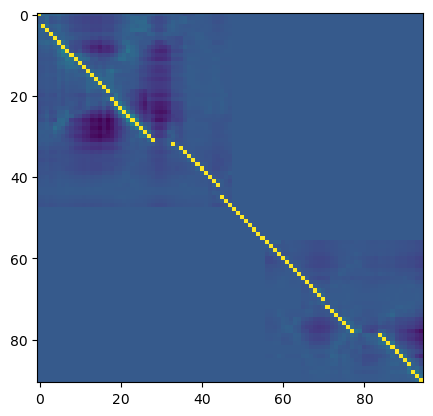

In [51]:
plt.imshow(S)

In [34]:
score_lolmat[43001]

724.4245586689182

In [40]:
score_lolmat[0]

0.0

In [73]:
df = pd.DataFrame([alignments[0].values, alignments[1].values, score_lolmat[:43002]]).T

In [3]:
df = pd.read_csv("hyperparameter/scope100_first1000_res_lol3diFB_highGP.csv", sep='\t', header=None)
df

,0,1,2,3,4,5
0,d3pt8a_,d3pt8a_,9021.002564,a.1.1.0,a.1.1.0,59.351270
1,d3pt8a_,d1b0ba_,5647.431123,a.1.1.0,a.1.1.2,36.727424
2,d3pt8a_,d1urva_,5524.694627,a.1.1.0,a.1.1.2,33.851177
3,d3pt8a_,d1naza_,5380.918028,a.1.1.0,a.1.1.2,33.146780
4,d3pt8a_,d1mbaa_,4940.139965,a.1.1.0,a.1.1.2,31.372450
...,...,...,...,...,...,...
42997,d1alla_,d2wf7a_,225.301136,a.1.1.3,c.108.1.6,0.834288
42998,d1alla_,d2o36a_,554.671782,a.1.1.3,d.92.1.5,0.824395
42999,d1alla_,d2f48a_,455.987079,a.1.1.3,c.89.1.1,0.794734
43000,d1alla_,d3oo3a_,304.912179,a.1.1.3,a.104.1.0,0.758216


In [4]:
df = df.sort_values([0,2], ascending=[False, False])
df.to_csv("hyperparameter/scope100_first1000_res_lol3diFB_highGP.csv", sep='\t', header=False, index = False)

In [ ]:
score_lolmat[]

In [126]:
score_lolmat.sum(), score_3di.sum(), score_anchor.sum()

(2264570.754876624, 2212141.947400867, 2265570.1179554663)

In [110]:
(score_lolmat[:481] - score_anchor[:481] <= 0).sum()

290

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  2.,  4.,  4., 15.,
        11., 12., 26., 33., 61., 95., 90., 37., 23., 11., 11.,  6.,  4.,
         3.,  6.,  2.,  3.,  1.,  2.,  1.,  0.,  2.,  1.,  0.,  1.,  2.,
         1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-352.6436186 , -334.22569183, -315.80776507, -297.3898383 ,
        -278.97191153, -260.55398476, -242.136058  , -223.71813123,
        -205.30020446, -186.88227769, -168.46435092, -150.04642416,
        -131.62849739, -113.21057062,  -94.79264385,  -76.37471709,
         -57.95679032,  -39.53886355,  -21.12093678,   -2.70301002,
          15.71491675,   34.13284352,   52.55077029,   70.96869705,
          89.38662382,  107.80455059,  126.22247736,  144.64040412,
         163.05833089,  181.47625766,  199.89418443,  218.3121112 ,
         236.73003796,  255.14796473,  273.5658915 ,  291.98381827,
         310.40174503,  328.8196718 ,  347.237

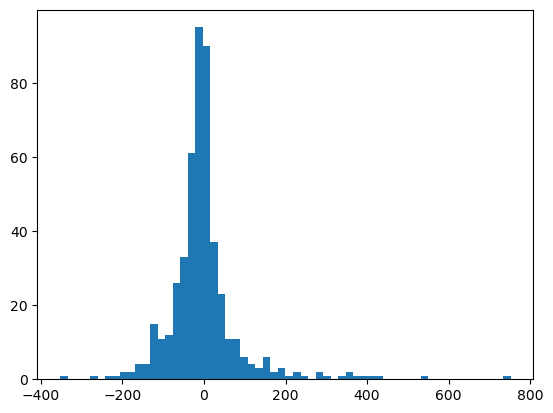

In [106]:
plt.hist(score_lolmat[:481] - score_anchor[:481], bins = 60)

Anchor new FB = 2259201
Anchor = 2266887

In [52]:
def calc_score2(S_all, d_mat_ij, d_mat_kl):
    lol_score =  0
    pre = np.longdouble
    
    all_lolscores = np.zeros(len(S_all))

    for i in range(len(S_all)):
        S = S_all[i]
        ap = np.argwhere(S >= 1e2)

        index_test = (ap[:,0]).reshape(-1)[None,:] - ap[:,1][:,None]
        d_mat_ij_test = d_mat_ij[:, ap[:,0]]
        d_mat_ij_test = d_mat_ij_test[ap[:,0], :]
        d_mat_kl_test = d_mat_kl[:,ap[:,1]]
        d_mat_kl_test = d_mat_kl_test[ap[:,1], :]
        d_mask_test = d_mat_ij_test > 0
        _lol_scores = np.zeros(d_mask_test.shape)
        #print(_lol_scores.shape)

        d_ij_test, d_kl_test, d_seq_test = d_mat_ij_test[d_mask_test], d_mat_kl_test[d_mask_test], index_test[d_mask_test]
        _lol_scores[d_mask_test] = lol_score_approx(d_ij_test, d_kl_test, d_seq_test)
        _lol_scores.reshape(d_mat_ij_test.shape)
        _lol_scores = _lol_scores/(np.sum(d_mask_test.reshape(d_mat_ij_test.shape), axis = 0)[:,None]+1)
        all_lolscores[i] = np.sum(_lol_scores)
    #print(all_lolscores)
    return np.max(all_lolscores)

In [39]:
def load_startAnchors(query,target):
    sa = []
    for i in range(2):
        sa.append(np.load("hyperparameter/start_anchors/"+query+"_"+target+"_"+str(i)+".npy"))
    return sa

In [40]:
def calc_startAnchors(S, fb_go, fb_ge, temp, le):
    start_anchors = []
    for i in range(2):
        P = fb_local(S, fb_go, fb_ge, temp, np.longdouble)
        x,y = np.unravel_index(np.argmax(P), P.shape)
        x,y = np.max([0,x-le]), np.max([0,y-le])
        #P -= np.max([0 ,np.max(P)-shift])
        bt, (s, q_gap, t_gap) = sw_align(np.array(P[x:x+(le*2),y:y+(le*2)], dtype = np.double), gap_open = 0, gap_extend=0)
        bt = np.array(bt)
        bt[:,0] += x
        bt[:,1] += y
        #print(bt)
        start_anchors.append(np.copy(bt))
        S[bt[:,0], bt[:,1]] = - 100
    return start_anchors

In [26]:
OrderedDict([('le', 4),
             ('sa_fb_ge', -11.123668493619709),
             ('sa_fb_go', -39.967973831048724),
             ('sa_temp', 10.534618768553978)])
OrderedDict([('lol_ge', 0),
              ('lol_go', -3),
              ('lol_min_m', 0.4),
              ('lol_temp', 2)]),

NameError: name 'OrderedDict' is not defined

In [4]:
class lol_alignment():
    def __init__(self, sa_fb_go=-3, sa_fb_ge=-2, sa_temp = 1, le = 3,
                 lol_go=-3, lol_ge=0, lol_min_m=0.4,  lol_red_t=0, lol_temp=2):
        self.sa_fb_go = sa_fb_go
        self.sa_fb_ge = sa_fb_ge
        self.sa_temp = sa_temp
        self.le = le
        self.lol_go = lol_go
        self.lol_ge = lol_ge 
        self.lol_min_m = lol_min_m
        self.lol_red_m = 0.1
        self.lol_red_t = lol_red_t
        self.lol_temp = lol_temp
        
        self.alignments = {}
        self.start_time = time.time()

    def fit(self, querys, targets,*kwargs):
        #Parallel(n_jobs=20) 
        for query,target in zip(querys, targets):
            coords1,_ = sid2coords.get(query)
            coords2,_ = sid2coords.get(target)
            coords1 = coords1[:,:3]
            coords2 = coords2[:,:3]
            d_mat_ij = distances(coords1, coords1)
            d_mat_ij[d_mat_ij > 15] = 0
            d_mat_kl = distances(coords2, coords2)
            d_mat_ij = np.asarray(d_mat_ij)
            d_mat_kl = np.asarray(d_mat_kl)
            aa1 = sid2seq_aa[query]
            aa2 = sid2seq_aa[target]
            ss1 = sid2seq_ss[query]
            ss2 = sid2seq_ss[target]
            S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
            startAnchors = calc_startAnchors(S, self.sa_fb_go, self.sa_fb_ge, self.sa_temp, self.le)
            #startAnchors = calc_startAnchors(S, self.sa_fb_go, self.sa_fb_ge, self.sa_sw_go, self.sa_sw_ge, self.sa_shift)
            #startAnchors = load_startAnchors(query,target)
            #print(startAnchors[0].shape)
            self.alignments[query+"_"+target] = align(S, startAnchors, self.lol_go, self.lol_ge, self.lol_min_m,
                                                    self.lol_red_m, self.lol_temp, self.lol_red_t, d_mat_ij, d_mat_kl)
            
        
        
        
        #self.result = measure_MI_for_virtc((self.a, self.b, self.l))
        
        
    def score(self, querys, targets,*kwargs):
        score = 0
        for query,target in zip(querys, targets):
            coords1,_ = sid2coords.get(query)
            coords2,_ = sid2coords.get(target)
            coords1 = coords1[:,:3]
            coords2 = coords2[:,:3]
            d_mat_ij = distances(coords1, coords1)
            d_mat_ij[d_mat_ij > 15] = 0
            d_mat_kl = distances(coords2, coords2)
            d_mat_ij = np.asarray(d_mat_ij)
            d_mat_kl = np.asarray(d_mat_kl)
            aa1 = sid2seq_aa[query]
            aa2 = sid2seq_aa[target]
            ss1 = sid2seq_ss[query]
            ss2 = sid2seq_ss[target]
            S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
            
            score += calc_score2(self.alignments[query+"_"+target], d_mat_ij, d_mat_kl)
        #print(self.get_params())
        print(score, time.time() - self.start_time)
        self.start_time = time.time()
        return score
    def get_params(self, *kwargs, deep = False):
        
        return {'sa_fb_go': self.sa_fb_go, 'sa_fb_ge': self.sa_fb_ge, 'lol_go' : self.lol_go,
               'lol_ge' : self.lol_ge, 'lol_min_m' : self.lol_min_m,
               'lol_red_t' : self.lol_red_t, 'sa_temp' : self.sa_temp, "le" : self.le}
    def set_params(self, lol_go, lol_ge, lol_min_m, lol_temp):


        #self.sa_fb_go = sa_fb_go
        #self.sa_fb_ge = sa_fb_ge
        #self.sa_sw_go = sa_sw_go
        #self.sa_sw_ge = sa_sw_ge
        #self.sa_shift = sa_shift
        #self.sa_temp = sa_temp
        #self.le = le
        self.lol_go = lol_go
        self.lol_ge = lol_ge 
        self.lol_min_m = lol_min_m
        #self.lol_red_m = lol_red_m
        #self.lol_red_t = lol_red_t
        #self.lol_th = lol_th
        self.lol_temp = lol_temp
        return self
    
opt = skopt.BayesSearchCV(lol_alignment(),
                              {'lol_go': (-10.1, 0., 'uniform'),
                              'lol_ge': (-8.1, 0, 'uniform'), 'lol_min_m' : (.4, .9, 'uniform'), 'lol_temp': (.5, 10.1, 'uniform')},
                              n_iter=200, cv=[(slice(None), slice(None))])

opt.fit(alignments['query'].values, alignments['target'].values)

NameError: name 'skopt' is not defined

In [74]:
for k, s in S_alignment.alignments.items():
    for i in range(10):
        np.save("hyperparameter/data/opt_anchorpoints/"+k+"_"+str(i)+".npy", s[i])

In [49]:
S_alignment = lol_alignment()
S_alignment.fit(alignments[0].values, alignments[1].values)

In [11]:
alignments

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
0,0,0,31394,d1f0ya2,d1nyta1,82,0.4025,4M1D8M1I12M1D11M8I6M4I6M12I27M2I27M4D10M2I4M,2,15,150,c.2.1.6,c.2.1.7,False,True,True,1,12,4M3D44M24I10M2D4M2I11M1D5M3I28M1D4M1D8M9I4M23I...,61
1,1,1,242793,d2cqqa1,d1rr7a_,33,0.5535,52M,1,43,52,a.4.1.3,a.4.1.14,False,True,True,1,46,22M3I27M,105
2,2,2,265209,d2g5ca2,d1e5qa1,72,0.4330,22M2I18M2I5M6D10M2D23M2I1M1I11M6D6M,4,5,117,c.2.1.6,c.2.1.3,False,True,True,1,2,22M2I30M7D5M1I26M3I7M1I14M3D8M1I5M9I21M7I9M,50
3,3,3,112775,d1osna_,d1odfa_,50,0.2827,15M1D6M2D16M11I3M1D7M2I6M3I4M6I5M6D12M10D5M5D7...,5,27,215,c.37.1.1,c.37.1.6,False,True,True,1,22,4M1D29M3D10M1I4M1I4M13I10M1I5M3D4M1D13M14D24M3...,59
4,4,4,54036,d1hyua4,d3fz9a_,65,0.5050,39M5I7M6D13M2D14M,3,1,86,c.47.1.2,c.47.1.0,False,True,True,3,1,39M5I10M4D9M4D19M1I5M2D5M8D1M,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,495,495,14540,d1cpqa_,d256ba_,95,0.5612,14M3I15M4D8M1I6M1I3M1I3M11I50M,11,4,120,a.24.3.2,a.24.3.1,False,True,True,8,1,20M3I25M2D4M12I55M,8
477,496,496,340716,d3gnja_,d1h75a_,90,0.5284,21M6I12M3D18M5I9M1I7M,25,2,82,c.47.1.0,c.47.1.1,False,True,True,24,1,25M6I19M3D10M5I9M1I4M1I4M2I2M,60
478,497,497,55670,d1i60a_,d1yx1a1,207,0.4871,5M4D29M4I23M1I3M3D2M1D8M8I21M1D7M9I9M3I19M2I13...,2,3,286,c.1.15.4,c.1.15.7,False,True,True,1,2,10M1D4M3D22M1I6M3I16M1I12M4I27M10I4M1I25M2I17M...,7
479,498,498,146136,d1ssqa_,d3bfpa_,37,0.2970,9M2D2M2D1M4I13M6D11M8I19M6D15M6D17M,140,74,121,b.81.1.6,b.81.1.8,False,True,True,4,1,6M18D4M13I11M44I7M9D13M3I10M10I28M2I26M8I47M1I5M,7


In [117]:
S_alignment.score(alignments['query'].values, alignments['target'].values)

2289217.670833648 627.2828018665314


2289217.670833648

In [5]:
%%time
import skopt

class lol_alignment():
    def __init__(self, sa_fb_go=-3, sa_fb_ge=-2, sa_sw_go=28, sa_sw_ge=4, sa_shift=0.19, sa_temp = 1, #sa_len = 3,
                 lol_go=-3.5, lol_ge=-0.3, lol_min_m=0.4, lol_red_m=0.1, lol_red_t=1, lol_th=0.84, lol_temp=10):
        self.sa_fb_go = sa_fb_go
        self.sa_fb_ge = sa_fb_ge
        self.sa_sw_go = sa_sw_go
        self.sa_sw_ge = sa_sw_ge
        self.sa_shift = sa_shift
        self.sa_temp = sa_temp
        self.lol_go = lol_go
        self.lol_ge = lol_ge 
        self.lol_min_m = lol_min_m
        self.lol_red_m = lol_red_m
        self.lol_red_t = lol_red_t
        self.lol_th = lol_th
        self.lol_temp = lol_temp
        #self.sa_len = sa_len
        self.alignments = {}

    def fit(self, querys, targets,*kwargs):
        for query,target in zip(querys, targets):
            coords1,_ = sid2coords.get(query)
            coords2,_ = sid2coords.get(target)
            coords1 = coords1[:,:3]
            coords2 = coords2[:,:3]
            d_mat_ij = distances(coords1, coords1)
            d_mat_ij[d_mat_ij > 15] = 0
            d_mat_kl = distances(coords2, coords2)
            d_mat_ij = np.asarray(d_mat_ij)
            d_mat_kl = np.asarray(d_mat_kl)
            aa1 = sid2seq_aa[query]
            aa2 = sid2seq_aa[target]
            ss1 = sid2seq_ss[query]
            ss2 = sid2seq_ss[target]
            S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
            #startAnchors = calc_startAnchors(S, self.sa_fb_go, self.sa_fb_ge, self.sa_sw_go, self.sa_sw_ge, self.sa_shift)
            startAnchors = load_startAnchors(query,target)
            #print(startAnchors[0].shape)
            self.alignments[query+"_"+target] = align(S, startAnchors, self.lol_go, self.lol_ge, self.lol_min_m,
                                                      self.lol_red_m, self.lol_temp, self.lol_red_t, d_mat_ij, d_mat_kl)
        
        
        
        #self.result = measure_MI_for_virtc((self.a, self.b, self.l))
        
        
    def score(self, querys, targets,*kwargs):
        score = 0
        for query,target in zip(querys, targets):
            coords1,_ = sid2coords.get(query)
            coords2,_ = sid2coords.get(target)
            coords1 = coords1[:,:3]
            coords2 = coords2[:,:3]
            d_mat_ij = distances(coords1, coords1)
            d_mat_ij[d_mat_ij > 15] = 0
            d_mat_kl = distances(coords2, coords2)
            d_mat_ij = np.asarray(d_mat_ij)
            d_mat_kl = np.asarray(d_mat_kl)
            aa1 = sid2seq_aa[query]
            aa2 = sid2seq_aa[target]
            ss1 = sid2seq_ss[query]
            ss2 = sid2seq_ss[target]
            S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
            
            score += calc_score2(self.alignments[query+"_"+target], self.lol_go, self.lol_ge, self.lol_temp, d_mat_ij, d_mat_kl)
        #print(self.get_params())
        print(score)
        return score
    def get_params(self, *kwargs, deep = False):
        
        return {'sa_fb_go': self.sa_fb_go, 'sa_fb_ge': self.sa_fb_ge, 'sa_sw_go': self.sa_sw_go, #'sa_len': self.sa_len, 
               'sa_sw_ge' : self.sa_sw_ge, 'sa_shift' : self.sa_shift, 'lol_go' : self.lol_go,
               'lol_ge' : self.lol_ge, 'lol_min_m' : self.lol_min_m, 'lol_red_m' : self.lol_red_m, 
               'lol_red_t' : self.lol_red_t, 'lol_th' : self.lol_th, 'lol_temp' : self.lol_th,
               'sa_temp' : self.sa_temp}
    
    
    #def set_params(self, sa_fb_go, sa_fb_ge, sa_sw_go, sa_sw_ge, sa_shift, lol_go, lol_ge, lol_min_m, lol_red_m, lol_red_t, lol_th, lol_temp):
    #def set_params(self, sa_shift, sa_temp, lol_min_m, lol_red_m, lol_red_t, lol_th, lol_temp):
    def set_params(self, lol_go, lol_ge, lol_min_m, lol_red_t, lol_temp):


        #self.sa_fb_go = sa_fb_go
        #self.sa_fb_ge = sa_fb_ge
        #self.sa_sw_go = sa_sw_go
        #self.sa_sw_ge = sa_sw_ge
        #self.sa_shift = sa_shift
        #self.sa_temp = sa_temp
        #self.sa_len = sa_len
        self.lol_go = lol_go
        self.lol_ge = lol_ge 
        self.lol_min_m = lol_min_m
        self.lol_red_t = lol_red_t
        #self.lol_red_t = lol_red_t
        #self.lol_th = lol_th
        self.lol_temp = lol_temp
        return self

#opt = skopt.BayesSearchCV(lol_alignment(),
#                              {'sa_fb_go': (0, 10, 'uniform'), 'sa_fb_ge': (0, 10, 'uniform'), 'sa_sw_go': (0, 40, 'uniform'),
#                              'sa_sw_ge': (0, 20, 'uniform'), 'sa_shift': (.1, .6, 'uniform'), 'lol_go': (0, 40, 'uniform'),
#                              'lol_ge': (0, 20, 'uniform'), 'lol_min_m' : (.4, .7, 'uniform'), 'lol_red_m': (.01, .3, 'uniform'),
#                              'lol_red_t' : (0, 3, 'uniform'), 'lol_th': (.4, 1, 'uniform'), 'lol_temp': (1, 10, 'uniform')},
#                              n_iter=20, cv=[(slice(None), slice(None))])
opt = skopt.BayesSearchCV(lol_alignment(),
                              {'lol_go': (-40.1, 0., 'uniform'),
                              'lol_ge': (-20., 0., 'uniform'), 'lol_min_m' : (.4, .9, 'uniform'), 'lol_red_t': (0, 2, 'uniform'), 'lol_temp': (1., 10., 'uniform')},
                              n_iter=20, cv=[(slice(None), slice(None))])

#opt = skopt.BayesSearchCV(lol_alignment(),
#                              {'sa_shift': (.01, .8, 'uniform'), 'lol_min_m' : (.4, .7, 'uniform'), 'lol_red_m': (.01, .3, 'uniform'),
#                              'sa_temp': (1, 10, 'uniform'), 'lol_red_t' : (0, 3, 'uniform'), 'lol_th': (.51, 1, 'uniform'), 'lol_temp': (1, 10, 'uniform')},
#                              n_iter=1000, cv=[(slice(None), slice(None))])

    

#opt.fit(alignments['query'].values,alignments['target'].values)

CPU times: user 9.45 ms, sys: 0 ns, total: 9.45 ms
Wall time: 11.3 ms


In [39]:
opt.fit(alignments['query'].values,alignments['target'].values)

1742118.2062982419
1830530.5984303786
1554955.3819122338
1793343.431063433
2059104.9783396749
1191747.593266835
1170274.1026846291
1818964.1124522733
1961774.4508277215
1101373.4734297656
777672.9624455858
2133629.121357447
2133688.3255338115
2134551.2488145614
2128991.9937628973
2138134.6425003842
2183533.2285594223
2179821.482737436
2190761.4702721187
2196135.854871709


BayesSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
              estimator=<__main__.lol_alignment object at 0x7e56ed62fbd0>,
              n_iter=20,
              search_spaces={'lol_ge': (-20, 0, 'uniform'),
                             'lol_go': (-40, 0, 'uniform'),
                             'lol_min_m': (0.4, 0.9, 'uniform'),
                             'lol_red_t': (0, 2, 'uniform'),
                             'lol_temp': (1, 10, 'uniform')})

In [39]:
time.time()

1714983242.595645

In [47]:
%%time
calc_al2 = lol_alignment()
calc_al2.fit(alignments['query'].values, alignments['target'].values)

CPU times: user 32min 2s, sys: 30min 15s, total: 1h 2min 18s
Wall time: 11min 24s


In [48]:
calc_al2.score(alignments['query'].values, alignments['target'].values)

29555.20767778676


29555.20767778676

In [45]:
calc_al.score(alignments['query'].values, alignments['target'].values)

31093.27654491283


31093.27654491283

In [39]:
31093.27654491283


29574.5360015956

In [64]:
opt.alignments

AttributeError: 'BayesSearchCV' object has no attribute 'alignments'

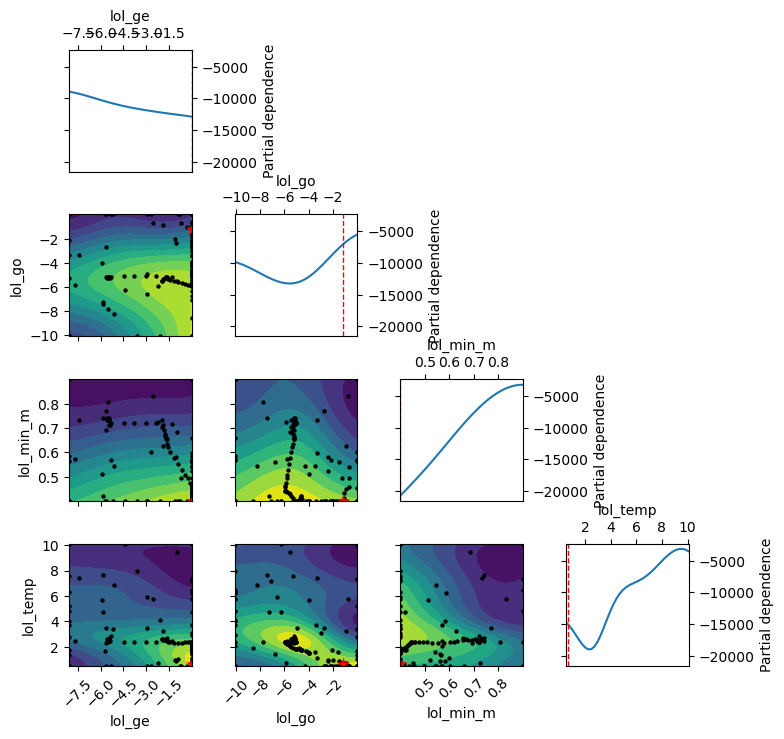

In [98]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(opt.optimizer_results_[0],
                   #dimensions=["lol_go", "lol_ge", "lol_min_m", "lol_red_t", "lol_temp"],
                   n_minimum_search=int(1e8))
plt.show()

In [100]:
opt.best_params_

OrderedDict([('lol_ge', 0.0),
             ('lol_go', -1.1842925199513186),
             ('lol_min_m', 0.4),
             ('lol_temp', 0.6191755338310712)])

In [78]:
opt.best_params_
alignments['query'].values[:10], alignments['target'].values[:10]

(array(['d1f0ya2', 'd2cqqa1', 'd2g5ca2', 'd1osna_', 'd1hyua4', 'd2b5dx2',
        'd1xt8a1', 'd1sc6a1', 'd1qx2a_', 'd3dkra_'], dtype=object),
 array(['d1nyta1', 'd1rr7a_', 'd1e5qa1', 'd1odfa_', 'd3fz9a_', 'd1o7d.3',
        'd2o1ma_', 'd1vl6a1', 'd1auib_', 'd1mj5a_'], dtype=object))

In [92]:
al_rescale = lol_alignment(lol_ge =  -.1, lol_go = -.5, lol_min_m = 0.4, lol_temp = 1)

In [93]:
al_rescale.fit(alignments['query'].values[:10], alignments['target'].values[:10])

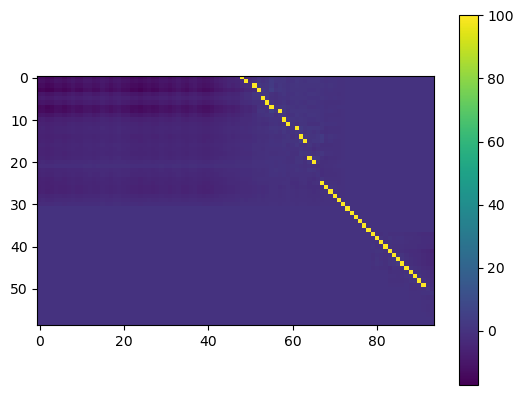

In [94]:
im = plt.imshow(al_rescale.alignments['d2cqqa1_d1rr7a_'][0])
plt.colorbar()

In [95]:
al_rescale.score(alignments['query'].values[:10], alignments['target'].values[:10])

759.882169943295 8.74179482460022


759.882169943295

In [62]:
opt.get_params()

{'cv': [(slice(None, None, None), slice(None, None, None))],
 'error_score': 'raise',
 'estimator__sa_fb_go': -3,
 'estimator__sa_fb_ge': -2,
 'estimator__lol_go': -3,
 'estimator__lol_ge': 0,
 'estimator__lol_min_m': 0.4,
 'estimator__lol_red_t': 0,
 'estimator__sa_temp': 1,
 'estimator__le': 3,
 'estimator': <__main__.lol_alignment at 0x795ca2ee8890>,
 'fit_params': None,
 'iid': 'deprecated',
 'n_iter': 200,
 'n_jobs': 1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'search_spaces': {'lol_go': (-10.1, 0.0, 'uniform'),
  'lol_ge': (-8.1, 0, 'uniform'),
  'lol_min_m': (0.4, 0.9, 'uniform'),
  'lol_temp': (1.1, 10.1, 'uniform')},
 'verbose': 0}

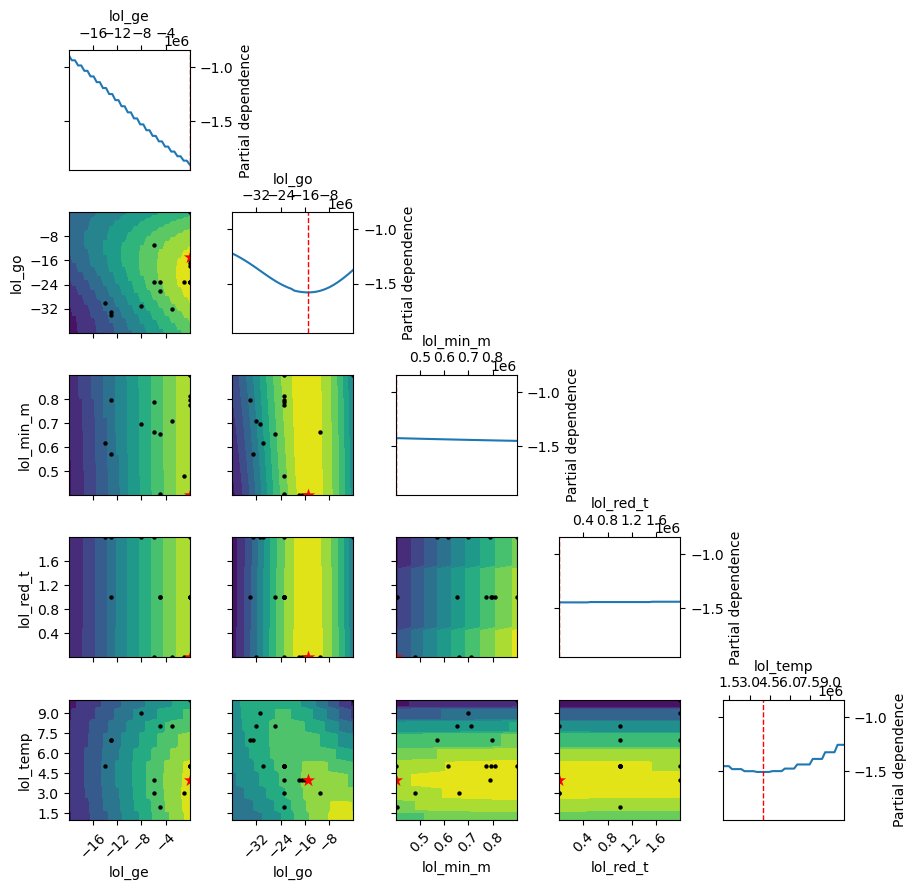

In [45]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["lol_ge", "lol_go", "lol_min_m", "lol_red_t", "lol_temp"],
                   n_minimum_search=int(1e8))
plt.show()

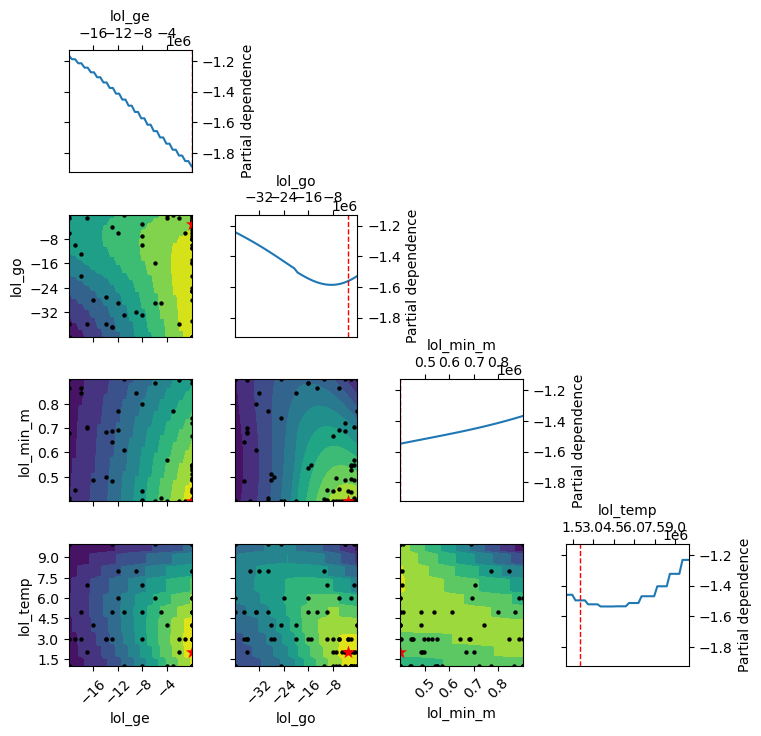

In [47]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_hpc.optimizer_results_[0],
                   dimensions=["lol_ge", "lol_go", "lol_min_m", "lol_temp"],
                   n_minimum_search=int(1e8))
plt.show()

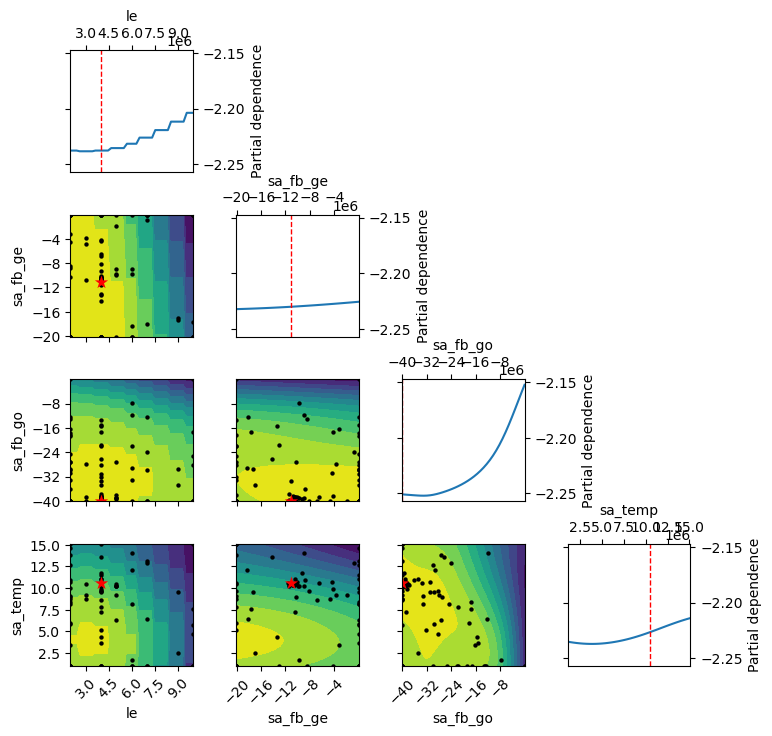

In [22]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt_seed.optimizer_results_[0],
                   #dimensions=["sa_fb_go", "sa_fb_ge", "sa_temp", "length"],
                   n_minimum_search=int(1e8))
plt.show()

In [44]:
opt_seed.estimator.get_params()#lol_alignment#.aignments

AttributeError: 'lol_alignment' object has no attribute 'sa_sw_go'

In [35]:
opt_seed.score(alignments['query'].values,alignments['target'].values)

2266887.0020699413


2266887.0020699413

In [36]:
opt_seed.best_score_

2266887.0020699413

In [23]:
opt_hpc.best_params_, opt.best_params_, opt_seed.best_params_

NameError: name 'opt_hpc' is not defined

In [7]:
opt_hpc

AttributeError: 'lol_alignment' object has no attribute 'sa_sw_go'

AttributeError: 'lol_alignment' object has no attribute 'sa_sw_go'

BayesSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
              estimator=<__main__.lol_alignment object at 0x7fa181a86a90>,
              n_iter=100,
              search_spaces={'le': (2, 10, 'uniform'),
                             'sa_fb_ge': (-20.1, 0, 'uniform'),
                             'sa_fb_go': (-40.1, 0, 'uniform'),
                             'sa_temp': (1.01, 15.1, 'uniform')})

In [29]:

dump(opt, 'first_hopt_result_local.pkl')

In [6]:
opt_hpc = load('hyperparameter/seed_hopt_result.pkl')

In [20]:
opt_seed = load('hyperparameter/seed_hopt_result.pkl')

In [27]:
opt_hpc.get_params()

{'cv': [(slice(None, None, None), slice(None, None, None))],
 'error_score': 'raise',
 'estimator__sa_fb_go': -3,
 'estimator__sa_fb_ge': -2,
 'estimator__sa_sw_go': 28,
 'estimator__sa_sw_ge': 4,
 'estimator__sa_shift': 0.19,
 'estimator__lol_go': -3.5,
 'estimator__lol_ge': -0.3,
 'estimator__lol_min_m': 0.5,
 'estimator__lol_red_m': 0.274,
 'estimator__lol_red_t': 3,
 'estimator__lol_th': 0.84,
 'estimator__lol_temp': 0.84,
 'estimator__sa_temp': 1,
 'estimator': <__main__.lol_alignment at 0x701d65ace550>,
 'fit_params': None,
 'iid': 'deprecated',
 'n_iter': 300,
 'n_jobs': -1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'search_spaces': {'lol_go': (-40, 0, 'uniform'),
  'lol_ge': (-20, 0, 'uniform'),
  'lol_min_m': (0.4, 0.7, 'uniform'),
  'lol_red_t': (0, 3, 'uniform'),
  'lol_th': (0.4, 1, 'uniform'),
  'lol_temp': (1, 10, 'uniform')},
 'verbose': 0}

In [38]:
opt.best_params_

OrderedDict([('lol_ge', -4),
             ('lol_go', -27),
             ('lol_min_m', 0.8259059893354084),
             ('lol_red_m', 0.10726038998813112),
             ('lol_temp', 9)])

In [22]:
opt_hpc.best_params_

OrderedDict([('lol_ge', 0),
             ('lol_go', -13),
             ('lol_min_m', 0.7),
             ('lol_red_t', 0),
             ('lol_temp', 1),
             ('lol_th', 0.7686932408487983)])

In [34]:
#opt.best_params_, 
opt_hpc.best_params_

(OrderedDict([('lol_ge', 0),
              ('lol_go', -9),
              ('lol_min_m', 0.4),
              ('lol_red_m', 0.1),
              ('lol_red_t', 3),
              ('lol_temp', 8),
              ('lol_th', 0.767699660628052)]),
 OrderedDict([('lol_ge', 0),
              ('lol_go', -9),
              ('lol_min_m', 0.4),
              ('lol_red_m', 0.1),
              ('lol_red_t', 3),
              ('lol_temp', 8),
              ('lol_th', 0.767699660628052)]))

In [538]:
opt.score(alignments['query'].values, alignments['target'].values)

/tmp/ipykernel_11999/3956763823.py:31: RuntimeWarning: overflow encountered in multiply
  ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) #+  * exp_ge_arr
/tmp/ipykernel_11999/3956763823.py:30: RuntimeWarning: overflow encountered in multiply
  zm[i,1:] = (zm[i-1, :-1] + ze[i-1,:-1] + zf[i-1,:-1]) * S[i-1,:]
/tmp/ipykernel_11999/3956763823.py:32: RuntimeWarning: overflow encountered in multiply
  zf[i,:] = zm[i-1,:] * exp_go + zf[i-1,:] * exp_ge
/tmp/ipykernel_11999/458314111.py:25: RuntimeWarning: overflow encountered in multiply
  P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1]) * np.exp(-S/T, dtype = pre)
/tmp/ipykernel_11999/458314111.py:25: RuntimeWarning: invalid value encountered in divide
  P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1]) * np.exp(-S/T, dtype = pre)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 109 but corresponding boolean dimension is 108

In [44]:
opt.best_params_

OrderedDict([('lol_ge', 7),
             ('lol_go', 7),
             ('lol_min_m', 0.5000531846205691),
             ('lol_red_m', 0.27467324958672845),
             ('lol_red_t', 3),
             ('lol_temp', 4),
             ('lol_th', 0.8325591831570971),
             ('sa_fb_ge', 2),
             ('sa_fb_go', 3),
             ('sa_shift', 0.18867912654640268),
             ('sa_sw_ge', 3),
             ('sa_sw_go', 28)])

In [31]:
alignments = pd.read_csv("hyperparameter/scope100_first1000_missing.csv", sep='\t', header=None)
alignments

,0,1,2,3
0,d1nvma2,d2duma_,2.075,15.0
1,d1nvma2,d1kjna_,7.029,15.0
2,d1nvma2,d1vh0a_,2.318,15.0
3,d1nvma2,d1ejba_,2.318,15.0
4,d1nvma2,d1rcua_,4.037,15.0
...,...,...,...,...
2479,d1bf6a_,d1sg4a1,7.893,6.0
2480,d1bf6a_,d1e2ka_,8.387,6.0
2481,d1bf6a_,d2bjfa_,6.579,6.0
2482,d1bf6a_,d1i24a_,9.470,6.0


In [9]:
alignments = pd.read_csv("hyperparameter/alignments.csv", sep=',')
alignments

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
0,0,0,31394,d1f0ya2,d1nyta1,82,0.4025,4M1D8M1I12M1D11M8I6M4I6M12I27M2I27M4D10M2I4M,2,15,150,c.2.1.6,c.2.1.7,False,True,True,1,12,4M3D44M24I10M2D4M2I11M1D5M3I28M1D4M1D8M9I4M23I...,61
1,1,1,242793,d2cqqa1,d1rr7a_,33,0.5535,52M,1,43,52,a.4.1.3,a.4.1.14,False,True,True,1,46,22M3I27M,105
2,2,2,265209,d2g5ca2,d1e5qa1,72,0.4330,22M2I18M2I5M6D10M2D23M2I1M1I11M6D6M,4,5,117,c.2.1.6,c.2.1.3,False,True,True,1,2,22M2I30M7D5M1I26M3I7M1I14M3D8M1I5M9I21M7I9M,50
3,3,3,112775,d1osna_,d1odfa_,50,0.2827,15M1D6M2D16M11I3M1D7M2I6M3I4M6I5M6D12M10D5M5D7...,5,27,215,c.37.1.1,c.37.1.6,False,True,True,1,22,4M1D29M3D10M1I4M1I4M13I10M1I5M3D4M1D13M14D24M3...,59
4,4,4,54036,d1hyua4,d3fz9a_,65,0.5050,39M5I7M6D13M2D14M,3,1,86,c.47.1.2,c.47.1.0,False,True,True,3,1,39M5I10M4D9M4D19M1I5M2D5M8D1M,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,495,495,14540,d1cpqa_,d256ba_,95,0.5612,14M3I15M4D8M1I6M1I3M1I3M11I50M,11,4,120,a.24.3.2,a.24.3.1,False,True,True,8,1,20M3I25M2D4M12I55M,8
477,496,496,340716,d3gnja_,d1h75a_,90,0.5284,21M6I12M3D18M5I9M1I7M,25,2,82,c.47.1.0,c.47.1.1,False,True,True,24,1,25M6I19M3D10M5I9M1I4M1I4M2I2M,60
478,497,497,55670,d1i60a_,d1yx1a1,207,0.4871,5M4D29M4I23M1I3M3D2M1D8M8I21M1D7M9I9M3I19M2I13...,2,3,286,c.1.15.4,c.1.15.7,False,True,True,1,2,10M1D4M3D22M1I6M3I16M1I12M4I27M10I4M1I25M2I17M...,7
479,498,498,146136,d1ssqa_,d3bfpa_,37,0.2970,9M2D2M2D1M4I13M6D11M8I19M6D15M6D17M,140,74,121,b.81.1.6,b.81.1.8,False,True,True,4,1,6M18D4M13I11M44I7M9D13M3I10M10I28M2I26M8I47M1I5M,7


In [22]:
alignments[(alignments[0] == query) & (alignments[1] == target)]

,0,1,2,3,4,5,6
32203,d2v33a_,d1r17a2,2.81,23,NaN,NaN,NaN


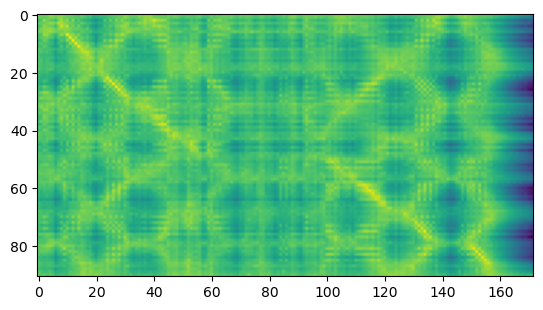

In [24]:
plt.imshow(np.load("./hyperparameter/scope100_first1000_3di/"+query+"_"+target+"_0.npy"))

In [25]:
target

'd1r17a2'

In [1]:
example_alignment = {'query': alignments['query'].values[100],
                    'target': alignments['target'].values[100],
                    'cigar': alignments['cigar_dali'].values[100] ,
                    'qstart': alignments['qstart_dali'].values[100] ,
                    'tstart': alignments['tstart_dali'].values[100] }

NameError: name 'alignments' is not defined

In [107]:
def distances_ij(q_points_aln, t_points_aln, cutoff=15):
    """intra-molecular distances with cutoff"""
    d_ij = np.sqrt(np.sum((q_points_aln[:, None] - q_points_aln[None, :])**2, axis=-1))
    d_kl = np.sqrt(np.sum((t_points_aln[:, None] - t_points_aln[None, :])**2, axis=-1))

    neighbor_mask = (d_ij < cutoff).astype(np.float32) * (1. - np.eye(len(d_ij)))
    return (neighbor_mask * d_ij, neighbor_mask * d_kl)

def align_coords(query, target, alignment):
    coords1, mask1 = query
    coords2, mask2 = target
    cigar, q_start, t_start = alignment

    idx1, idx2 = sautils.common.parse_cigar(cigar, query=q_start, ref=t_start, include_m=True, order_qt=True).T

    # Remove masked residues from alignment
    mask = mask1[idx1] & mask2[idx2]
    aln_coords1 = coords1[idx1, :3][mask]  # need only CA
    aln_coords2 = coords2[idx2, :3][mask]    
    return (aln_coords1, aln_coords2), (idx1, idx2), (len(coords1), len(coords2))

In [108]:
coords1, mask1 = sid2coords.get(example_alignment['query'])
coords2, mask2 = sid2coords.get(example_alignment['target'])    
(aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
        align_coords((coords1, mask1),
                     (coords2, mask2),
                     (example_alignment['cigar'], example_alignment['qstart'], example_alignment['tstart']))   

In [109]:
example_alignment['target']

'd3bb9a1'

In [137]:
aa1 = sid2seq_aa[example_alignment['query']]
aa2 = sid2seq_aa[example_alignment['target']]
ss1 = sid2seq_ss[example_alignment['query']]
ss2 = sid2seq_ss[example_alignment['target']]


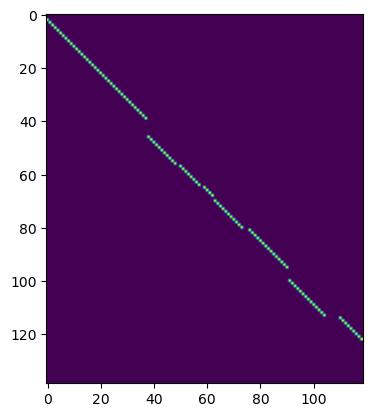

In [138]:
P = np.zeros_like(S)
P[idx1,idx2] = 1
plt.imshow(P)

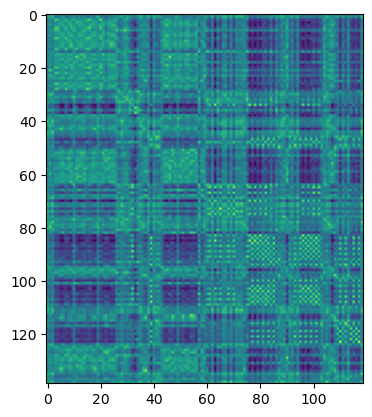

In [112]:
plt.imshow(S)

In [102]:
sa = calc_startAnchors(S, 1, .01, 100, 10, .01)

TypeError: calc_startAnchors() takes 5 positional arguments but 6 were given

In [103]:
final_sa = []
for i in range(len(sa)):
    mask = []
    check = False
    for j in range(sa[i].shape[0]):
        if P[sa[i][j,0], sa[i][j,1]] == 1:
            mask.append(True)
            check = True
        else:
            mask.append(False)
    if check:
        final_sa.append(sa[i][mask,:])
        #sa[i] = np.isin(sa[i], np.array(idx1,idx2)

NameError: name 'sa' is not defined

In [104]:
len(final_sa)

0

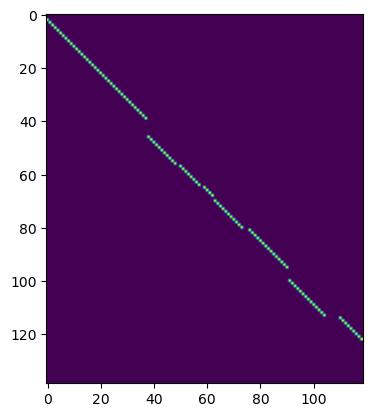

In [113]:
for i in range(len(final_sa)):
    P[final_sa[i][:,0], final_sa[i][:,1]] = 2
plt.imshow(P)

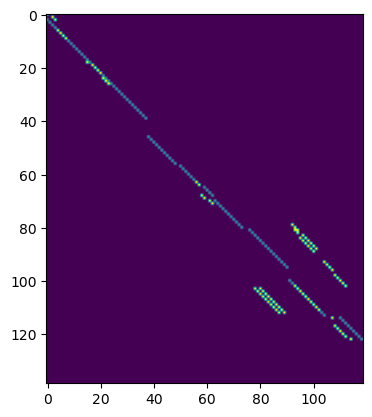

In [139]:
for i in range(len(sa)):
    P[sa[i][:,0], sa[i][:,1]] = 2
plt.imshow(P)

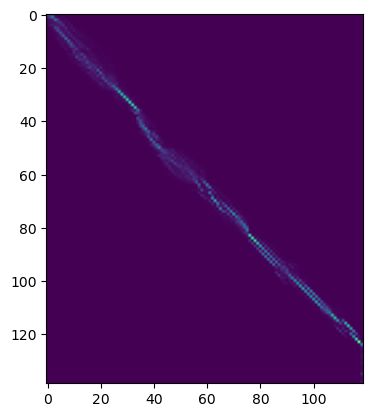

In [122]:
plt.imshow(fb_local(S, -10, -1, 10, np.longdouble))

In [118]:
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)


In [ ]:
for i in range(10):

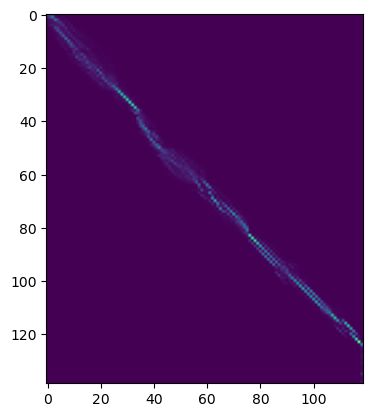

In [126]:
plt.imshow(P)

In [125]:
P = fb_local(S, -10, -1, 10, np.longdouble)
np.argmax(P, axis = 1)

array([  0,   2,   3,   5,   6,   3,   4,   5,   6,   7,   8,   9,   9,
        11,  10,  13,  11,  12,  15,  17,  16,  19,  20,  21,  21,  22,
        23,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  33,  35,
        34,  35,  35,  36,  37,  38,  38,  38,  39,  40,  41,  42,  43,
        44,  47,  46,  47,  48,  50,  52,  54,  54,  55,  55,  59,  60,
        61,  58,  61,  62,  62,  63,  64,  67,  65,  69,  70,  71,  72,
        73,  74,  74,  75,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        82,  83,  84,  85,  89,  90,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 112,
       113, 114, 115, 114, 115, 116, 117, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 118, 118])

In [127]:
np.unravel_index(np.argmax(P), P.shape)

(123, 117)

In [135]:
sa = calc_startAnchors(S, -10, -1, 10, 5)

0 0
[[0 0]
 [1 2]
 [2 3]
 [6 4]
 [7 5]
 [8 6]
 [9 7]]
63 53
[[63 56]
 [64 57]
 [68 58]
 [69 59]
 [70 61]
 [71 62]]
93 103
[[ 93 104]
 [ 94 105]
 [ 95 106]
 [ 96 107]
 [ 98 108]
 [ 99 109]
 [100 110]
 [101 111]
 [102 112]]
103 80
[[103  80]
 [104  81]
 [105  82]
 [106  83]
 [107  84]
 [108  85]
 [109  86]
 [110  87]
 [111  88]
 [112  89]]
114 105
[[114 107]
 [117 108]
 [118 109]
 [119 110]
 [120 111]
 [121 112]
 [122 114]]
17 15
[[18 15]
 [19 17]
 [20 18]
 [21 19]
 [22 20]
 [24 21]
 [25 22]
 [26 23]]
103 78
[[103  78]
 [104  79]
 [105  80]
 [106  81]
 [107  82]
 [108  83]
 [109  84]
 [110  85]
 [111  86]
 [112  87]]
80 91
[[ 80  93]
 [ 81  94]
 [ 84  95]
 [ 85  96]
 [ 86  97]
 [ 87  98]
 [ 88  99]
 [ 89 100]]
102 93
[[102  93]
 [103  94]
 [104  95]
 [105  96]
 [106  97]
 [107  98]
 [108  99]
 [109 100]
 [110 101]
 [111 102]]
79 92
[[ 79  92]
 [ 81  93]
 [ 82  94]
 [ 83  96]
 [ 84  97]
 [ 85  98]
 [ 86  99]
 [ 87 100]
 [ 88 101]]


In [35]:
def calc_startAnchors(S, fb_go, fb_ge, temp, le):
    start_anchors = []
    for i in range(2):
        P = fb_local(S, fb_go, fb_ge, temp, np.longdouble)
        x,y = np.unravel_index(np.argmax(P), P.shape)
        x,y = np.max([0,x-le]), np.max([0,y-le])
        #P -= np.max([0 ,np.max(P)-shift])
        bt, (s, q_gap, t_gap) = sw_align(np.array(P[x:x+(le*2),y:y+(le*2)], dtype = np.double), gap_open = 0, gap_extend=0)
        bt = np.array(bt)
        bt[:,0] += x
        bt[:,1] += y
        start_anchors.append(np.copy(bt))
        S[bt[:,0], bt[:,1]] = - 100
    return start_anchors

In [525]:
alignments.shape[0]

481

In [527]:
qd = -1
AL = alignments.copy()
for q in range(alignments.shape[0]):
    qd+=1
    example_alignment = {'query': alignments['query'].values[q],
                    'target': alignments['target'].values[q],
                    'cigar': alignments['cigar_dali'].values[q] ,
                    'qstart': alignments['qstart_dali'].values[q] ,
                    'tstart': alignments['tstart_dali'].values[q] }
    coords1, mask1 = sid2coords.get(example_alignment['query'])
    coords2, mask2 = sid2coords.get(example_alignment['target'])    
    (aln_coords1, aln_coords2), (idx1, idx2), (len1, len2) =\
            align_coords((coords1, mask1),
                         (coords2, mask2),
                         (example_alignment['cigar'], example_alignment['qstart'], example_alignment['tstart'])) 
    aa1 = sid2seq_aa[example_alignment['query']]
    aa2 = sid2seq_aa[example_alignment['target']]
    ss1 = sid2seq_ss[example_alignment['query']]
    ss2 = sid2seq_ss[example_alignment['target']]
    S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
    P = np.zeros_like(S)
    P[idx1,idx2] = 1
    sa = calc_startAnchors(S, 1, .01, 100, 10, .01)
    final_sa = []
    for i in range(len(sa)):
        mask = []
        check = False
        for j in range(sa[i].shape[0]):
            if P[sa[i][j,0], sa[i][j,1]] == 1:
                mask.append(True)
                check = True
            else:
                mask.append(False)
        if check:
            final_sa.append(sa[i][mask,:])
    for i in range(np.min([len(final_sa),2])):
        np.save("hyperparameter/start_anchors/"+alignments['query'].values[q]+"_"+alignments['target'].values[q]+"_"+str(i)+".npy", final_sa[i])
    if len(final_sa) < 2:
        AL = AL.drop([q])
        qd-=1
        print(alignments['query'].values[q], alignments['target'].values[q])

In [509]:
AL

,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
0,0,31394,d1f0ya2,d1nyta1,82,0.4025,4M1D8M1I12M1D11M8I6M4I6M12I27M2I27M4D10M2I4M,2,15,150,c.2.1.6,c.2.1.7,False,True,True,1,12,4M3D44M24I10M2D4M2I11M1D5M3I28M1D4M1D8M9I4M23I...,61
1,1,242793,d2cqqa1,d1rr7a_,33,0.5535,52M,1,43,52,a.4.1.3,a.4.1.14,False,True,True,1,46,22M3I27M,105
2,2,265209,d2g5ca2,d1e5qa1,72,0.4330,22M2I18M2I5M6D10M2D23M2I1M1I11M6D6M,4,5,117,c.2.1.6,c.2.1.3,False,True,True,1,2,22M2I30M7D5M1I26M3I7M1I14M3D8M1I5M9I21M7I9M,50
3,3,112775,d1osna_,d1odfa_,50,0.2827,15M1D6M2D16M11I3M1D7M2I6M3I4M6I5M6D12M10D5M5D7...,5,27,215,c.37.1.1,c.37.1.6,False,True,True,1,22,4M1D29M3D10M1I4M1I4M13I10M1I5M3D4M1D13M14D24M3...,59
4,4,54036,d1hyua4,d3fz9a_,65,0.5050,39M5I7M6D13M2D14M,3,1,86,c.47.1.2,c.47.1.0,False,True,True,3,1,39M5I10M4D9M4D19M1I5M2D5M8D1M,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,14540,d1cpqa_,d256ba_,95,0.5612,14M3I15M4D8M1I6M1I3M1I3M11I50M,11,4,120,a.24.3.2,a.24.3.1,False,True,True,8,1,20M3I25M2D4M12I55M,8
496,496,340716,d3gnja_,d1h75a_,90,0.5284,21M6I12M3D18M5I9M1I7M,25,2,82,c.47.1.0,c.47.1.1,False,True,True,24,1,25M6I19M3D10M5I9M1I4M1I4M2I2M,60
497,497,55670,d1i60a_,d1yx1a1,207,0.4871,5M4D29M4I23M1I3M3D2M1D8M8I21M1D7M9I9M3I19M2I13...,2,3,286,c.1.15.4,c.1.15.7,False,True,True,1,2,10M1D4M3D22M1I6M3I16M1I12M4I27M10I4M1I25M2I17M...,7
498,498,146136,d1ssqa_,d3bfpa_,37,0.2970,9M2D2M2D1M4I13M6D11M8I19M6D15M6D17M,140,74,121,b.81.1.6,b.81.1.8,False,True,True,4,1,6M18D4M13I11M44I7M9D13M3I10M10I28M2I26M8I47M1I5M,7
